In [1]:
# OpenAI Gym
import gym_tetris as gym
import gym.spaces
import numpy as np
import keras

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output
import cv2

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


Using TensorFlow backend.


In [2]:
env = gym.make('Tetris-v0')
downsize = (10,20)
observation=env.reset()

In [3]:
def resize(img,downsize):
    resized = cv2.resize(img,
                         dsize=downsize,
                         interpolation=cv2.INTER_CUBIC)
    return resized

In [4]:
resized_observation = resize(observation[17:423,7:212],downsize)
in_size = resized_observation.shape
obs_size = resized_observation.size
action_space = 6
display(in_size)
display(obs_size)
display(action_space)

(20, 10, 3)

600

6

In [5]:
def make_model(state, action_size):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=(20, 10), activation='relu',
                                    input_shape=[state.shape[0],
                                                 state.shape[1],
                                                 state.shape[2]]))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
    return model

model = make_model(resize(observation,downsize), 
                   action_space)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 64)          38464     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 64)          4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1, 64)          4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 126       
Total para

In [6]:
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = [state_size.shape[0], state_size.shape[1], state_size.shape[2]]
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size, 
                                       self.state_size[0], 
                                       self.state_size[1], 
                                       self.state_size[2]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size, 
                                    self.state_size[0], 
                                    self.state_size[1],
                                    self.state_size[2]])
        self.done = [False]*memory_size # Boolean (terminal transition?)
        
    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            model_targets = model.predict(current_state)
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model.predict(next_state),axis=1)

            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets

            # Update the weights accordingly
            model.fit(current_state,model_targets,epochs=1,verbose=0,batch_size=sample_size)

        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [7]:
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.2
episodes = 30000


replay_iterations = 50
replay_sample_size = 1024

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)
rewards = deque(maxlen=episodes)
epsilons = deque(maxlen=episodes)
max_Qs = deque(maxlen=episodes)
min_Qs = deque(maxlen=episodes)
avg_Qs = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym.make('Tetris-v0')
observation = env.reset()
resized_obs = resize(observation[17:423,7:212],downsize)
model = make_model(resized_obs, action_space)
target_model = make_model(resized_obs, action_space)
memory = ReplayMemory(30000, resized_obs, action_space)

In [14]:
model.load_weights('weights.h5')

In [9]:
#Run this when display surface quit
env = gym.make('Tetris-v0')
observation = env.reset()

In [38]:
model.save_weights('weights.h5')

In [13]:
done = False
epsilon=epsilon_min
# Perform the training!
cleared=0
for episode in range(episodes):
    env.close()
    env = gym.make('Tetris-v0')
    current_state = env.reset()
    current_state = current_state[17:423,7:212]
    time = 0
    total_reward = 0.0
    total_Q = 0
    max_Q=-9999
    min_Q=9999
    height=0
    prev_act=0
    while not done:
        resize_state=resize(current_state,downsize)
        #Only one action every 3 frames
        if not time%3:
            Q = model.predict(np.expand_dims(resize_state, axis=0)) # Compute Q
            #Action:
            #0: do nothing
            #1: left
            #2: right
            #3: down
            #4: rotate right
            #5: rotate left
            action = np.random.choice(action_space) if np.random.random() < epsilon else np.argmax(Q)
            next_state, reward, done, info = env.step(action) # take action!
            next_height=info['height']
            if next_height > 17:
                done=True
            elif height < next_height:
                #Rewards when block drops 
                #Height increase so give negative reward
                if next_height-height > 1:
                    reward-=0.1*pow((next_height-height),2)
                    height=next_height
            elif next_height < height and abs(height-next_height)<4:
                #Reward when block drops
                #Height decrease (cleared row) so give reward
                reward+=5*pow((next_height-height),2)
                height=next_height
                cleared+=height-next_height
            else:
                #Rewards
                blockpercol=np.zeros([10])
                for col in range(0,10):
                    for row in range(0,20):
                        #Check how many blocks in each column
                        if resize_state[row][col][0] > 0 or resize_state[row][col][1] > 0 or resize_state[row][col][2] > 0:
                            blockpercol[col]+=1
                #Give reward for spreading
                #Punishment for stacking
                reward+=0.05*(np.sum(blockpercol)-1.35*np.amax(blockpercol))
                if height > 0:
                    #Check the distribution of the blocks
                    if np.sum(blockpercol[:4]) > np.sum(blockpercol[5:]):
                        leftheavy=True
                        rightheavy=False
                    else:
                        leftheavy=False
                        rightheavy=True
                    #Give reward if moving towards the side with less blocks
                    if action==1 and rightheavy or action==2 and leftheavy:
                        reward+=0.25
                #Negative reward for doing nothing or drop straight down
                if action==0:
                    reward-=1
                #Negative reward for repeating same action
                if prev_act==action and action!=4 and action!=5:
                    reward-=0.5
                if action==3 and np.sum(blockpercol)<60:
                    reward-1
                prev_act=action
            if done:
                reward -= 10.0
            reward+=0.0025*time-1.3
            reward=reward/2
            #Plotting purpose
            total_reward += reward
            curr_Q=Q[0][action]
            if curr_Q > max_Q:
                max_Q = curr_Q
            elif curr_Q < min_Q:
                min_Q = curr_Q
            total_Q += curr_Q
            memory.remember(resize_state, action,reward,resize(next_state[17:423,7:212],downsize),done) # Store in memory...
        else:
            action=0
            next_state, reward, done, info = env.step(action)
        time += 1
        current_state = next_state[17:423,7:212] # Transition to next state!
    #Not using epsilon decay
    #epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min 
    #Plotting purpose
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    epsilons.append(epsilon)
    max_Qs.append(max_Q)
    min_Qs.append(min_Q)
    avg_Q=total_Q/((time+1)/3)
    avg_Qs.append(avg_Q)
    done = False
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f, reward: %g, Average Q: %g, Max Q: %g, Min Q: %g, Cleared: %d'%(episode+1,
                                                                                                                                 episodes,
                                                                                                                                 time,
                                                                                                                                 mean_time,
                                                                                                                                 epsilon,
                                                                                                                                 total_reward,
                                                                                                                                 avg_Q,
                                                                                                                                 max_Q,
                                                                                                                                 min_Q,
                                                                                                                                 cleared),end='')
    if (not episode%70) and episode > 1:
        model.save_weights('weights.h5')
        print(' Saved')
print()

Episode 16/30000 - time: 454, mean-time: 817, epsilon: 0.200000, reward: -53.2225, Average Q: 10.5736, Max Q: 14.1654, Min Q: 3.14617, Cleared: 0

KeyboardInterrupt: 

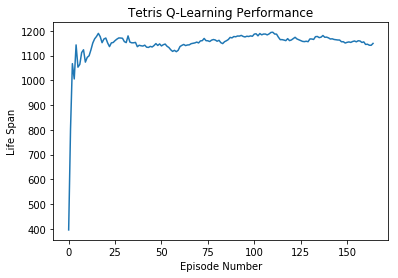

In [11]:
plt.plot(mean_times)
plt.title("Tetris Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Life Span")
plt.show()

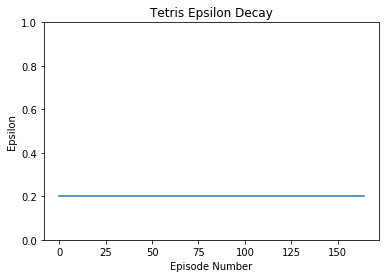

In [12]:
plt.plot(epsilons)
plt.ylim(top=1, bottom=0)
plt.title("Tetris Epsilon Decay")
plt.xlabel("Episode Number")
plt.ylabel("Epsilon")
plt.show()

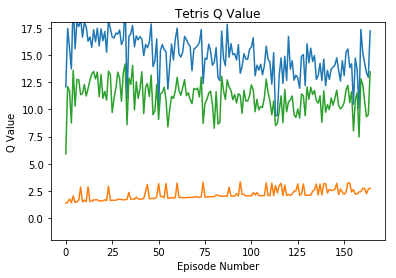

In [13]:
plt.ylim(top=18)
plt.ylim(bottom=-2)
plt.plot(max_Qs)
plt.plot(min_Qs)
plt.plot(avg_Qs)
plt.title("Tetris Q Value")
plt.xlabel("Episode Number")
plt.ylabel("Q Value")
plt.show()

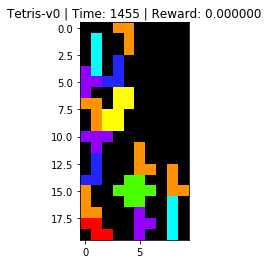

In [12]:
# Test out the agent!
# Initialize the environment and let the agent decide how to act!
env.close()
env = gym.make('Tetris-v0')
observation = env.reset()
done = False
time = 0
reward = 0.0
while not done:
    if not time%3:
        obs = resize(observation[17:423,7:212],downsize)
        plt.imshow(obs)
        plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
        clear_output(wait=True)
        Q = model.predict(np.expand_dims(obs,axis=0))
        action = np.argmax(Q)
        print('{} '.format(action))
        observation, reward, done, info = env.step(action)
        next_height=info['height']
        if (done):
            break
    else:
        action=0
        observation, reward, done, info = env.step(action)
    time+=1
clear_output(wait=True)

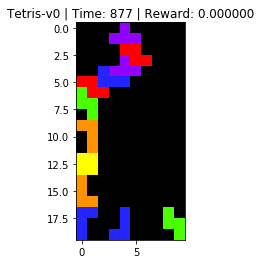

Run: 1

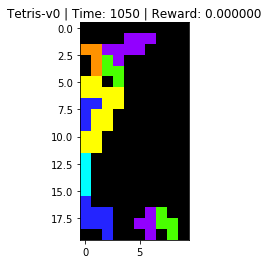

Run: 2

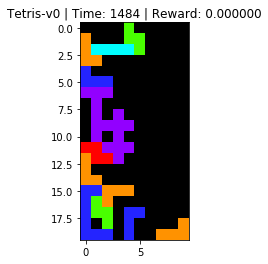

Run: 3

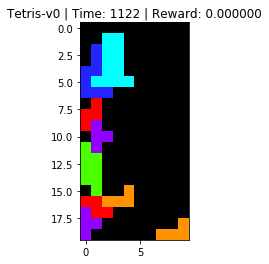

Run: 4

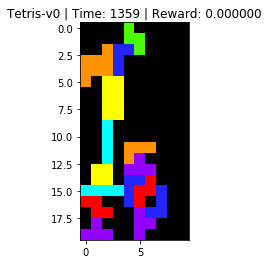

Run: 5

In [ ]:
# Testing the agent
testsize=15
done = False
result_times = deque(maxlen=testsize)
env.close()
env = gym.make('Tetris-v0')
score=0
for episode in range(testsize):
    current_state = env.reset()
    current_state = current_state[17:423,7:212]
    result_time = 0
    while not done:
        if not result_time%3:
            Q = model.predict(np.expand_dims(resize(current_state, downsize), axis=0)) # Compute Q
            action = np.argmax(Q)
            next_state, reward, done, info = env.step(action) # take action!
            score+=reward
            current_state = next_state[17:423,7:212] # Transition to next state!
        else:
            action=0
            next_state, reward, done, info = env.step(action)
        result_time += 1
    result_times.append(result_time)
    mean_result = np.mean(result_times)
    done = False
    plt.imshow(resize(current_state,downsize))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, result_time, reward))
    display(plt.gcf())
    print('\rRun: %d'%(episode+1),end='')
print('\nDone, mean-time: %d, score: %d'%(mean_result, score))

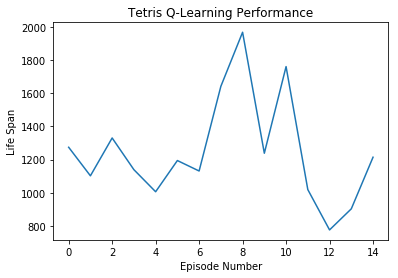

In [34]:
plt.plot(result_times)
plt.title("Tetris Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Life Span")
plt.show()